In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import PIL
from sklearn.metrics import classification_report
from tensorflow import device
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.applications.xception import Xception, preprocess_input

In [2]:
def create(data):
    items = pathlib.Path(data)
    images = pd.Series(list(items.glob('**/*.JPG')) + list(items.glob('**/*.jpg')) + list(items.glob('**/*.png')) + list(items.glob('**/*.PNG'))).astype(str)
    labels = pd.Series([os.path.split(os.path.split(x)[0])[1] for x in images])
    return pd.DataFrame({'Image': images, 'Label': labels})

In [3]:
path = "C:\\Users\\Admin\\OneDrive - Đại học FPT- FPT University\\This PC\\Documents\\Datasets\\birds\\"

df_train = create(f"{path}train")
df_valid = create(f"{path}valid")
df_test = create(f"{path}test")

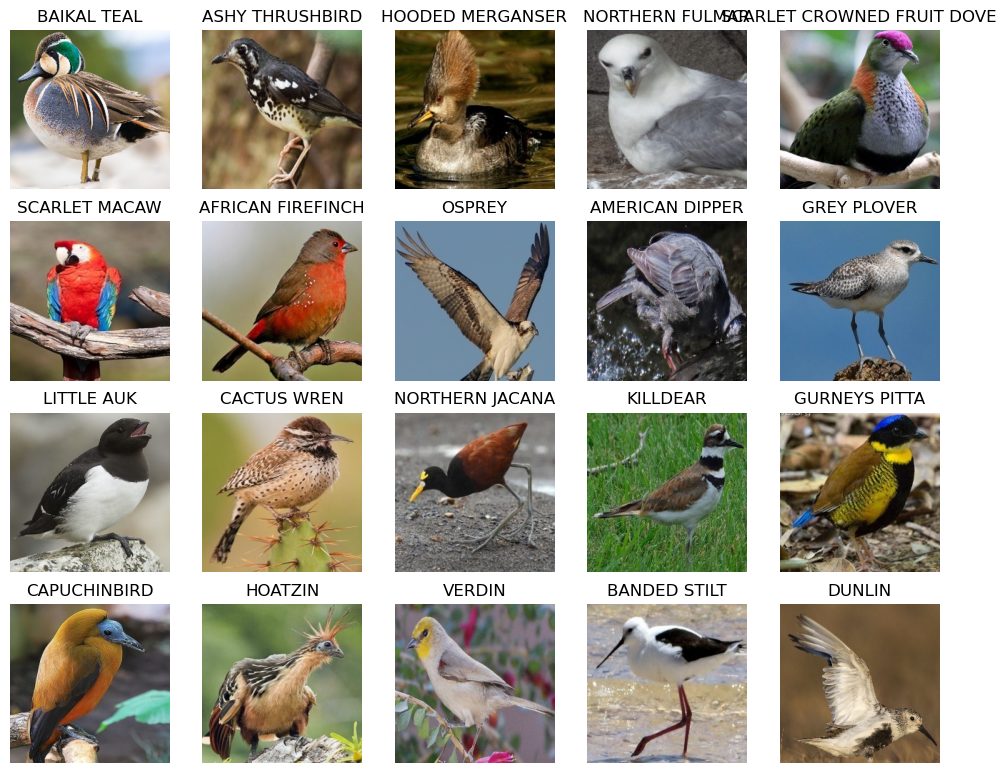

In [4]:
plt.figure(figsize=(12, 12))
for i, row in df_valid.sample(n=20).reset_index().iterrows():
    plt.subplot(5, 5, i + 1)
    instance = row['Image']
    image = PIL.Image.open(instance)
    plt.imshow(image)
    plt.title(row['Label'])
    plt.axis('off')
plt.show()

In [5]:
gen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
gen_valid = ImageDataGenerator(preprocessing_function=preprocess_input)
gen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

train = gen_train.flow_from_dataframe(
    dataframe=df_train,
    x_col='Image',
    y_col='Label',
    shuffle=True,
    seed=42,
)

valid = gen_valid.flow_from_dataframe(
    dataframe=df_valid,
    x_col='Image',
    y_col='Label',
    shuffle=True,
    seed=42
)

test = gen_test.flow_from_dataframe(
    dataframe=df_test,
    x_col='Image',
    y_col='Label',
    shuffle=False
)

Found 169270 validated image filenames belonging to 525 classes.
Found 5250 validated image filenames belonging to 525 classes.
Found 5250 validated image filenames belonging to 525 classes.


In [6]:
model = Xception(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling='max')
model.trainable = False

output = model.output
output = Dense(1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(512, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(525, activation='softmax')(output)

model = Model(inputs=model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(show_trainable=True)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                N          
                                )                                                                            
                                                                                                             
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           N      

In [7]:
def lr_schedule(epoch):
    return 0.001 if epoch < 10 else 0.0001

with device('/device:gpu:0'):
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    history = model.fit(train, steps_per_epoch=len(train), validation_data=valid, validation_steps=len(valid), callbacks=[early_stopping, lr_scheduler], epochs=30, verbose=1)

Epoch 1/30
5290/5290 [==============================] - 2524s 476ms/step - loss: 2.2858 - accuracy: 0.4545 - val_loss: 0.8072 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 2/30
5290/5290 [==============================] - 2303s 435ms/step - loss: 1.6082 - accuracy: 0.5878 - val_loss: 0.7254 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 3/30
5290/5290 [==============================] - 1987s 376ms/step - loss: 1.4523 - accuracy: 0.6238 - val_loss: 0.5988 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 4/30
5290/5290 [==============================] - 2628s 497ms/step - loss: 1.3560 - accuracy: 0.6461 - val_loss: 0.5536 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 5/30
5290/5290 [==============================] - 2670s 505ms/step - loss: 1.2947 - accuracy: 0.6606 - val_loss: 0.4886 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 6/30
5290/5290 [==============================] - 2661s 503ms/step - loss: 1.2460 - accuracy: 0.6726 - val_loss: 0.4971 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 7/30
5290/5290 [======

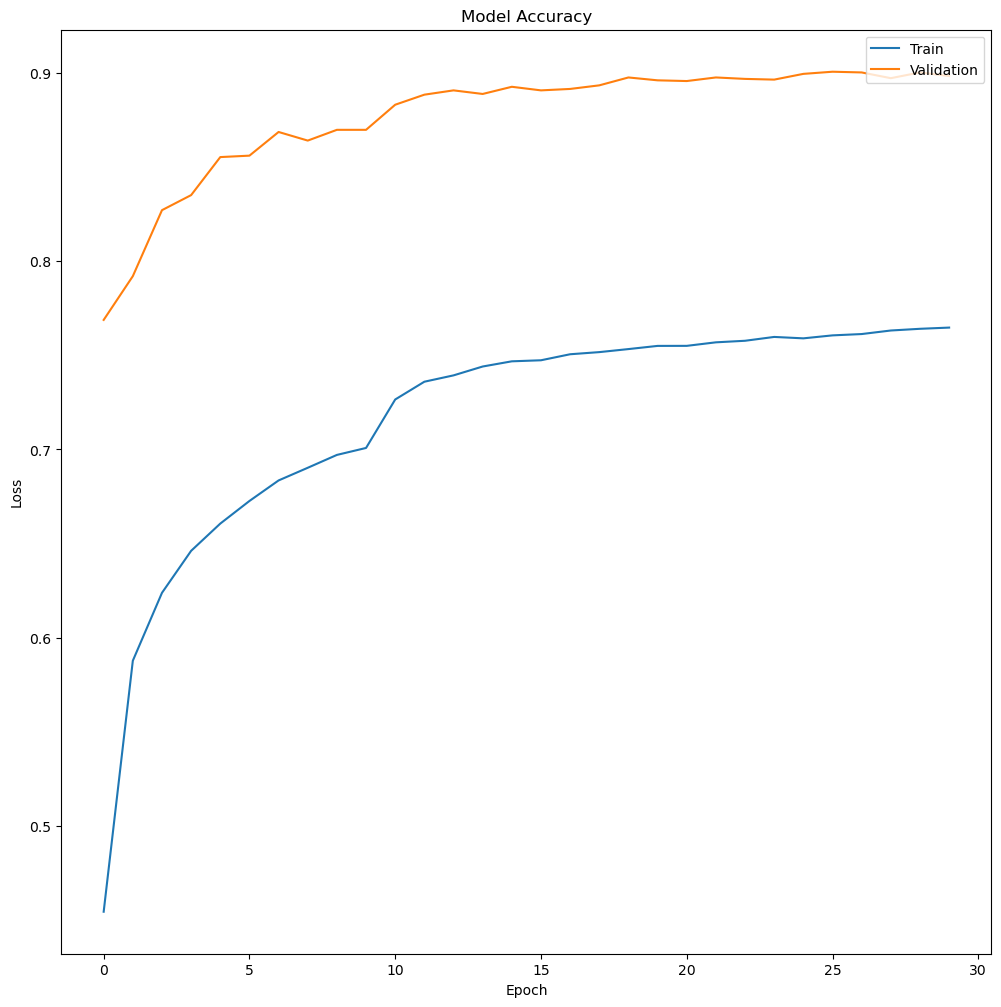

In [8]:
plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

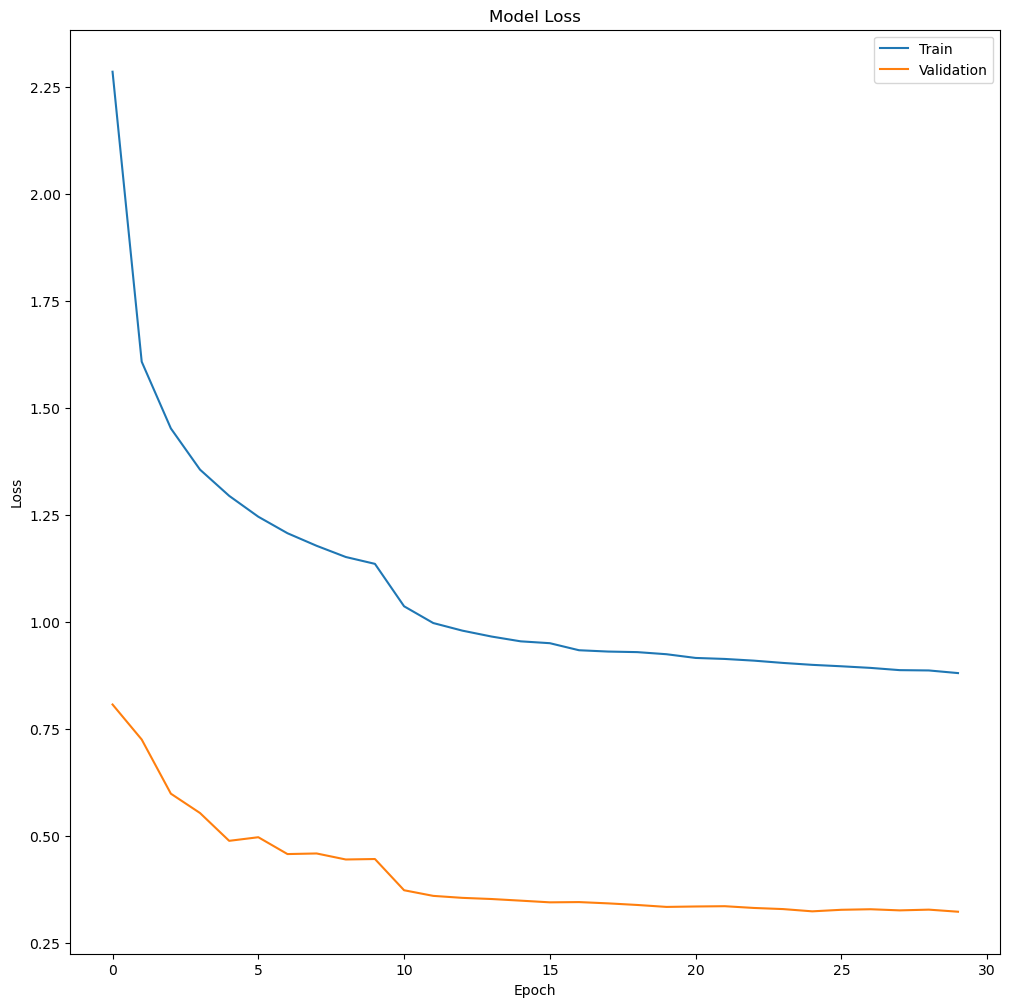

In [9]:
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [10]:
model.save("birds.h5")

In [11]:
name = "birds.h5"
model = load_model(name)

In [12]:
metrics = model.evaluate(test)
print("Test Loss:", metrics[0])
print("Test Accuracy:", metrics[1])

165/165 [==============================] - 19s 112ms/step - loss: 0.2414 - accuracy: 0.9394
Test Loss: 0.2414254993200302
Test Accuracy: 0.9394285678863525


In [13]:
pred_test = model.predict(test)

165/165 [==============================] - 19s 112ms/step


In [15]:
y_true = test.labels
y_pred = np.argmax(pred_test, axis=1)

report = classification_report(y_true, y_pred)

print(report)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.80      0.89        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       0.83      1.00      0.91        10
           6       1.00      1.00      1.00        10
           7       1.00      0.60      0.75        10
           8       1.00      1.00      1.00        10
           9       0.83      1.00      0.91        10
          10       1.00      1.00      1.00        10
          11       1.00      0.80      0.89        10
          12       1.00      0.80      0.89        10
          13       1.00      0.40      0.57        10
          14       1.00      0.60      0.75        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

c:\Users\Admin\AppData\Local\Programs\Anaconda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Anaconda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Anaconda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera